In [1]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
import numpy as np


In [2]:
## library options
sns.set(color_codes=True, palette="colorblind")
sns.set(rc={'figure.figsize':(10,7)})
pd.options.display.max_columns = 50

In [3]:
# Reading the data

bets = pd.read_csv("../data/bets.zip")
booking = pd.read_csv("../data/booking.zip")
goals = pd.read_csv("../data/goals.zip")
matches = pd.read_csv("../data/matches.zip")
stats = pd.read_csv("../data/stats.zip")

In [4]:
bets.head(1)

,match_id,odd_bookmakers,odd_epoch,variable,value
0,146845,BetOlimp,1486301854,odd_1,1.96


In [5]:
booking.head(1)

,match_id,time,home_fault,card,away_fault
0,13327,90+3,Can E.,yellow card,NaN


In [6]:
goals.head(1)

,match_id,time,home_scorer,score,away_scorer
0,13327,30,Salah M.,1 - 1,NaN


In [7]:
matches.head(1)

,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
0,7109,7097,41196,1505559600,Finished,0,Levante,Valencia,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,468


In [8]:
stats.head(1)

,match_id,home_BallPossession,home_CornerKicks,home_Fouls,home_GoalAttempts,home_GoalkeeperSaves,home_Offsides,home_ShotsoffGoal,home_ShotsonGoal,home_YellowCards,away_BallPossession,away_CornerKicks,away_Fouls,away_GoalAttempts,away_GoalkeeperSaves,away_Offsides,away_ShotsoffGoal,away_ShotsonGoal,away_YellowCards,home_BlockedShots,away_BlockedShots,home_FreeKicks,away_FreeKicks,home_Throw-in,away_Throw-in,home_RedCards,away_RedCards,home_Tackles,home_TotalPasses,away_Tackles,away_TotalPasses,home_CompletedPasses,away_CompletedPasses,home_GoalKicks,away_GoalKicks,home_DistanceCovered(metres),away_DistanceCovered(metres),home_PassSuccess%,away_PassSuccess%,home_Attacks,home_DangerousAttacks,away_Attacks,away_DangerousAttacks
0,13327,71%,12.0,7.0,35.0,3.0,1.0,14.0,9.0,1.0,29%,2.0,9.0,5.0,8.0,5.0,1.0,4.0,2.0,12.0,0.0,14.0,8.0,NaN,NaN,NaN,NaN,6.0,676.0,11.0,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis & Data Cleaning
We need to subset our datasets to English Premiere League matches

In [9]:
print(len(bets))
print(len(booking))
print(len(goals))
print(len(matches))
print(len(stats))

2143909
16615
11826
5169
4034


In [10]:
PREMIERE_LEAGUE_ID = 148
matches = matches[matches['league_id'] == PREMIERE_LEAGUE_ID].reset_index(drop=True)
bets = bets.merge(matches[['match_id']], on='match_id').reset_index(drop=True)
booking = booking.merge(matches[['match_id']], on='match_id').reset_index(drop=True)
goals = goals.merge(matches[['match_id']], on='match_id').reset_index(drop=True)
stats = stats.merge(matches[['match_id']], on='match_id').reset_index(drop=True)

In [11]:
print(len(bets))
print(len(booking))
print(len(goals))
print(len(matches))
print(len(stats))

311731
1579
1405
628
499


In [12]:
# observing unique values for each column to see whether something's wrong

for cols in matches.columns:
  if cols not in ['match_id', 'epoch']:
    print(cols)
    print(matches[cols].unique())

match_awayteam_id
[2614 2626 2629 2641 2617 2612 2628 2615 2619 2627 2621 2630 2646 2611
 2613 2616 2620 2632 2623 2654]
match_hometeam_id
[2619 2623 2621 2654 2616 2627 2620 2612 2626 2614 2611 2613 2615 2617
 2630 2628 2629 2646 2641 2632]
match_status
['Finished' nan]
match_live
[0]
match_hometeam_name
['Crystal Palace' 'Watford' 'Liverpool' 'Sheffield Utd' 'Chelsea'
 'Manchester United' 'West Ham' 'Everton' 'Manchester City' 'Southampton'
 'Leicester' 'Brighton' 'Bournemouth' 'Arsenal' 'Newcastle Utd'
 'Tottenham' 'Burnley' 'Wolves' 'Norwich' 'Newcastle' 'Aston Villa'
 'West Ham (Eng)' 'Manchester Utd']
match_awayteam_name
['Southampton' 'Manchester City' 'Burnley' 'Norwich' 'Arsenal' 'Everton'
 'Tottenham' 'Bournemouth' 'Crystal Palace' 'Manchester United'
 'Liverpool' 'Newcastle Utd' 'Wolves' 'Leicester' 'Brighton' 'Chelsea'
 'West Ham' 'Aston Villa' 'Watford' 'Newcastle' 'Sheffield Utd'
 'Aston Villa (Eng)' 'Manchester Utd']
match_hometeam_score
[ 0.  1.  4.  2.  5.  3.  6.  8. 

- There are some matches with Finished and nan status.
- Names of teams can be stored differently (Manchester United and Manchester Utd or West Ham and West Ham (Eng))
- There were some away teams that are not from Premiere league (champions league matches), but they're removed somehow, just beware of this.
- There are nan scores in some of the scores columns, these should be removed.

In [13]:
# Converting epoch column to datetime
matches['timestamp'] = matches['epoch'].apply(lambda x: dt.datetime.fromtimestamp(x))
bets['timestamp'] = bets['odd_epoch'].apply(lambda x: dt.datetime.fromtimestamp(x))

In [14]:
# matches whose match_status is NaN are not played yet, we can remove these data from our base data.
print('Number of rows before removing nans: {}'.format(len(matches)))
matches = matches.dropna(subset=['match_status', 'match_hometeam_score', 'match_awayteam_score'])
print('Number of rows after removing nans: {}'.format(len(matches)))

Number of rows before removing nans: 628
Number of rows after removing nans: 618


## Task1

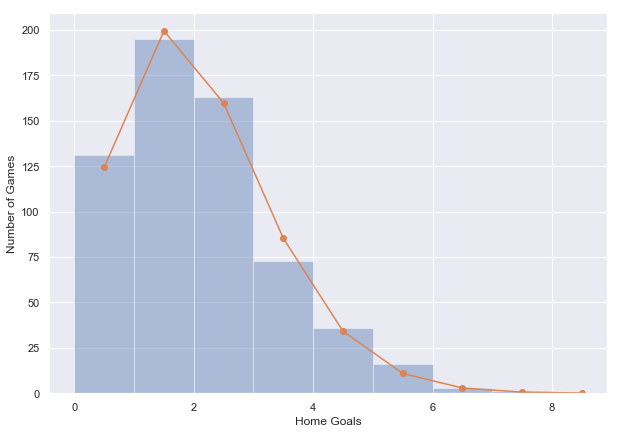

In [15]:
# Drawing histogram of home goals

# range of observations
bin_number = int(matches.match_hometeam_score.max() - 
                 matches.match_hometeam_score.min())

sns.distplot(matches.match_hometeam_score, 
             kde=False, 
             bins=bin_number)

plt.xlabel("Home Goals")
plt.ylabel("Number of Games")

# Fitting Poisson distribution on it, by using lambda as mean of all observations
mean = matches.match_hometeam_score.mean()
k = np.arange(matches.match_hometeam_score.max()+1)

plt.plot(k+0.5, poisson.pmf(k, mean)*len(matches.match_hometeam_score), 'o-')

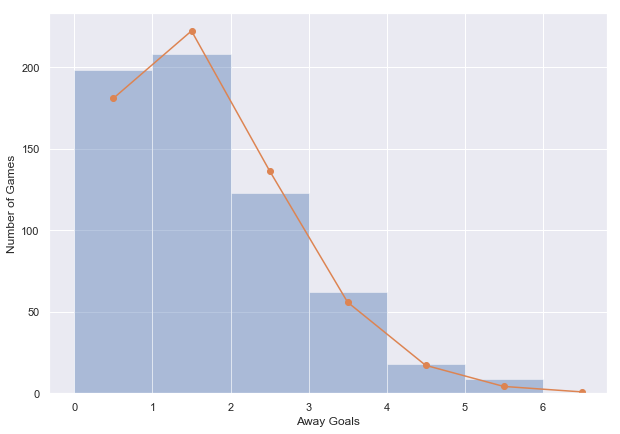

In [16]:
# Drawing histogram of away goals

bin_number = int(matches.match_awayteam_score.max() - 
                 matches.match_awayteam_score.min())

sns.distplot(matches.match_awayteam_score, 
             kde=False, 
             bins=bin_number)

plt.xlabel("Away Goals")
plt.ylabel("Number of Games")

# Fitting Poisson on to it
k = np.arange(matches.match_awayteam_score.max()+1) # length of observed values to calculate prob for each
                                                    # like [0, 1, 2, 3, ..., n], values will be shifted 0.5 to be centered
mean = matches.match_awayteam_score.mean() # mean values of observations

plt.plot(k+0.5, poisson.pmf(k, mean)*len(matches.match_awayteam_score), 'o-')

Text(0, 0.5, 'Number of Games')

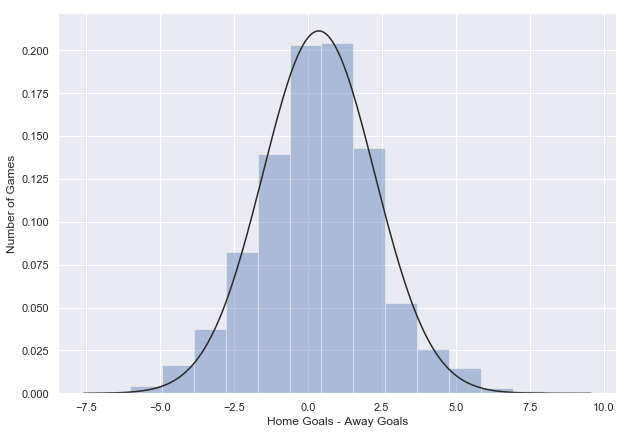

In [17]:
bin_number = int((matches.match_hometeam_score - matches.match_awayteam_score).max() - 
                 (matches.match_hometeam_score - matches.match_awayteam_score).min())

sns.distplot(matches.match_hometeam_score - matches.match_awayteam_score,
             kde=False,
             bins=13, 
             fit=norm) # this will fit normal distribution on it
plt.xlabel("Home Goals - Away Goals")
plt.ylabel("Number of Games")

In [18]:
print('Mean of home_score - away_score is {}'
      .format((matches.match_hometeam_score - matches.match_awayteam_score).mean()))
print('Std of home_score - away_score is {}'
      .format((matches.match_hometeam_score - matches.match_awayteam_score).std()))

Mean of home_score - away_score is 0.3737864077669903
Std of home_score - away_score is 1.889429497135252


## Task2


In [19]:
# subsetting bets to odd1 oddx odd2 only
print(len(bets))
bets = bets[bets['variable'].isin(['odd_1', 'odd_x', 'odd_2'])]
print(len(bets))

311731
58395


In [20]:
# pivoting bets data to see the changes with time easily and 
# see the odds in a single row for each match - bookmaker - timestamp

bets = bets.pivot_table(index=['match_id', 'odd_bookmakers', 'timestamp'],
                        columns='variable',
                        values='value').reset_index()

# reordering columns
bets = bets[['match_id', 'odd_bookmakers', 'odd_1', 'odd_x', 'odd_2', 'timestamp']]

In [21]:
bets.head()

variable,match_id,odd_bookmakers,odd_1,odd_x,odd_2,timestamp
0,150842,1xBet,5.10,3.7,1.77,2017-02-10 10:23:41
1,150842,Marathonbet,5.20,3.7,1.75,2017-02-10 10:23:41
2,150844,1xBet,3.09,3.3,2.46,2017-02-10 10:23:46
3,150844,Marathonbet,3.10,3.3,2.44,2017-02-10 10:23:46
4,150844,bwin,2.55,3.3,2.40,2017-02-10 10:23:46


In [22]:
# odds shouldn't be less than 1
bets = bets[(bets['odd_1'] > 1) & (bets['odd_x'] > 1) & (bets['odd_2'] > 1)]

In [23]:
# Since bets are changing by time, I will use final odds announced by bookmakers
# by assuming they are correcting their odds somehow

final_bets = bets.groupby(['match_id', 'odd_bookmakers'], as_index=False).last()
final_bets.head()

variable,match_id,odd_bookmakers,odd_1,odd_x,odd_2,timestamp
0,150842,1xBet,5.10,3.7,1.77,2017-02-10 10:23:41
1,150842,Marathonbet,5.20,3.7,1.75,2017-02-10 10:23:41
2,150844,1xBet,3.09,3.3,2.46,2017-02-10 10:23:46
3,150844,Marathonbet,3.10,3.3,2.44,2017-02-10 10:23:46
4,150844,bwin,2.55,3.3,2.40,2017-02-10 10:23:46


In [24]:
# Calculating implied naive probabilities and creating new prob_odd_1(x,2) columns
for cols in ['odd_1', 'odd_x', 'odd_2']:
  final_bets['prob_'+cols] = 1 / final_bets[cols]

# Summing all naive probabilities for each bookmaker & match (this will give us 1 + margin of bookmaker)
final_bets['total'] = final_bets['prob_odd_1'] + final_bets['prob_odd_x'] + final_bets['prob_odd_2']

# normalizin odd by removing margin share from each of them
for cols in ['odd_1', 'odd_x', 'odd_2']:
  final_bets['norm_prob_'+cols] = final_bets['prob_'+cols] / final_bets['total']

In [25]:
# creates a result column 1, 0 or 2 for home win, draw, away win accordingly

matches['result'] = np.where(matches.match_hometeam_score > matches.match_awayteam_score, 
                             1, 0)
# if away > home, then returns 2. otherwise returns the previous result value 
# (which is 1 if home > away and 0 otherwise)

matches['result'] = np.where(matches.match_hometeam_score < matches.match_awayteam_score, 
                             2, matches.result)

# joining result info into the final bets table

final_bets = final_bets.merge(matches[['match_id', 'result']], 
                              on='match_id')
final_bets.head()

,match_id,odd_bookmakers,odd_1,odd_x,odd_2,timestamp,prob_odd_1,prob_odd_x,prob_odd_2,total,norm_prob_odd_1,norm_prob_odd_x,norm_prob_odd_2,result
0,150842,1xBet,5.10,3.7,1.77,2017-02-10 10:23:41,0.196078,0.27027,0.564972,1.031320,0.190124,0.262062,0.547814,0
1,150842,Marathonbet,5.20,3.7,1.75,2017-02-10 10:23:41,0.192308,0.27027,0.571429,1.034007,0.185983,0.261382,0.552635,0
2,150844,1xBet,3.09,3.3,2.46,2017-02-10 10:23:46,0.323625,0.30303,0.406504,1.033159,0.313238,0.293305,0.393457,1
3,150844,Marathonbet,3.10,3.3,2.44,2017-02-10 10:23:46,0.322581,0.30303,0.409836,1.035447,0.311538,0.292657,0.395806,1
4,150844,bwin,2.55,3.3,2.40,2017-02-10 10:23:46,0.392157,0.30303,0.416667,1.111854,0.352705,0.272545,0.374749,1


In [26]:
# to create an array like [-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]
bins = 10
slices = np.linspace(-1, 1, bins+1, True).astype(np.float)

def convert_to_bin(num):
  """
  for each num returns the average value of previous and next observations in slices array
  
  ex:
  
  array = [-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]
  num = 0.72
  
  output = (0.6 + 0.8) / 2
  """
  return min([round((slices[i-1] + slices[i]) / 2, 2) for i,x in enumerate(slices) if num <= x])

In [27]:
final_bets['diff'] = final_bets['norm_prob_odd_1'] - final_bets['norm_prob_odd_2']
final_bets['bins'] = final_bets['diff'].apply(lambda x: convert_to_bin(x))

In [28]:
def plot_bookmaker_odds(df, plot_name, critical_df=None):
  prob_bins = df.groupby(['bins'], as_index=False)[['match_id']].count()
  draws = df[df['result'] == 0].groupby(['bins'], as_index=False)[['match_id']].count()
  prob_bins = prob_bins.merge(draws, on='bins', how='outer').fillna(0)
  prob_bins['draw_ratio'] = prob_bins['match_id_y'] / prob_bins['match_id_x']

  avg_result = df.groupby('bins', as_index=False)[['norm_prob_odd_x']].mean()
  prob_bins = prob_bins.merge(avg_result, on='bins', how='outer').fillna(0)
  prob_bins.columns = ['bins', 'total_matches', 'draw_matches', 'draw_ratio', 'mean_draw_prob']
  ax = sns.scatterplot(x="diff", 
                       y="norm_prob_odd_x",
                       data=df).set_title(plot_name)
  plt.plot(prob_bins.bins,
           prob_bins.draw_ratio,
           'o-',
           alpha=1)
  plt.plot(prob_bins.bins,
           prob_bins.mean_draw_prob,
           'o-',
           alpha=1)
  label_list = ['Actual Draw Ratios', 'Mean Draw Probs', 'Implied Draw Probs']
  if critical_df is not None:
    critical_prob_bins = critical_df.groupby(['bins'], as_index=False)[['match_id']].count()
    critical_draws = critical_df[critical_df['result'] == 0].groupby(['bins'], as_index=False)[['match_id']].count()
    critical_prob_bins = critical_prob_bins.merge(critical_draws, on='bins', how='outer').fillna(0)
    critical_prob_bins['draw_ratio'] = critical_prob_bins['match_id_y'] / critical_prob_bins['match_id_x']
    # cric_avg_result = critical_df.groupby('bins', as_index=False)[['norm_prob_odd_x']].mean()
    # critical_prob_bins = critical_prob_bins.merge(cric_avg_result, on='bins', how='outer').fillna(0)
    # critical_prob_bins.columns = ['bins', 'total_matches', 'draw_matches', 'draw_ratio', 'mean_draw_prob']
    plt.plot(critical_prob_bins.bins,
             critical_prob_bins.draw_ratio,
             'o-',
             alpha=1)
    # plt.plot(critical_prob_bins.bins,
    #          critical_prob_bins.mean_draw_prob,
    #          'o-',
    #          alpha=1)
  
    label_list = ['Actual Draw Ratios', 'Mean Draw Probs', 'Actual Draw Ratios - Smoothed', 'Implied Draw Probs']

  plt.xlabel('P(Home) - P(Away)')
  plt.ylabel('P(Draw)')
  plt.legend(loc='upper right', labels=label_list)

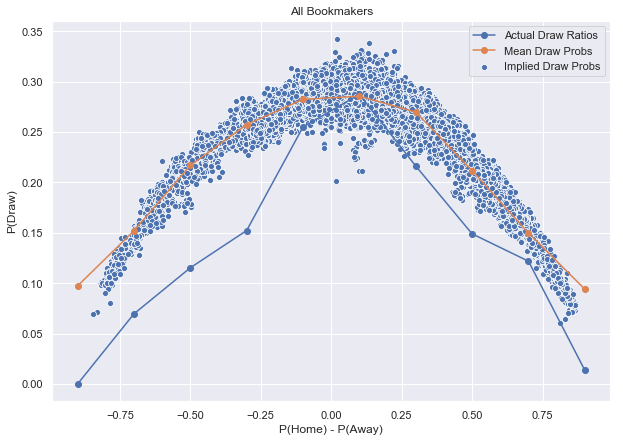

In [29]:
plot_bookmaker_odds(final_bets , 'All Bookmakers')

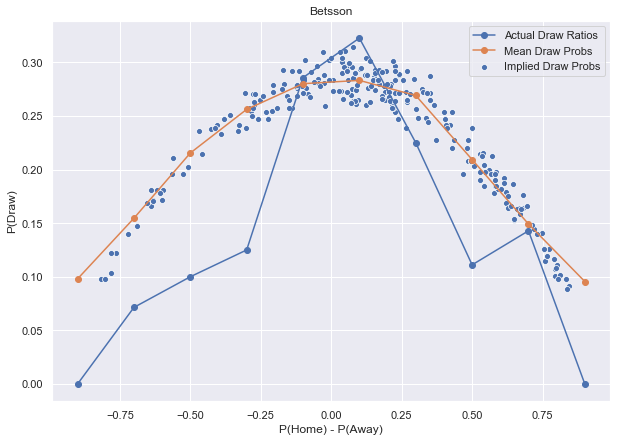

In [30]:
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == 'Betsson'], 'Betsson')

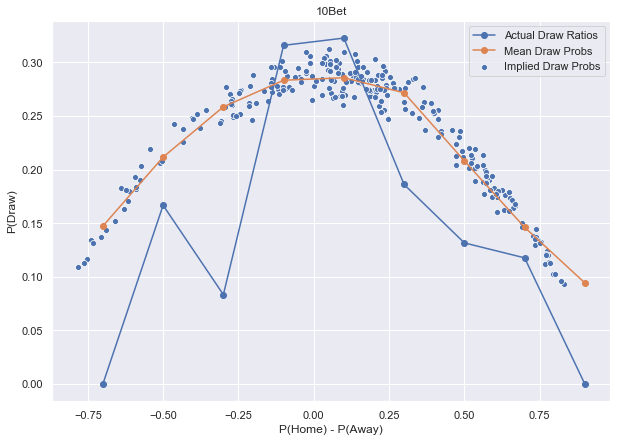

In [31]:
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '10Bet'], '10Bet')

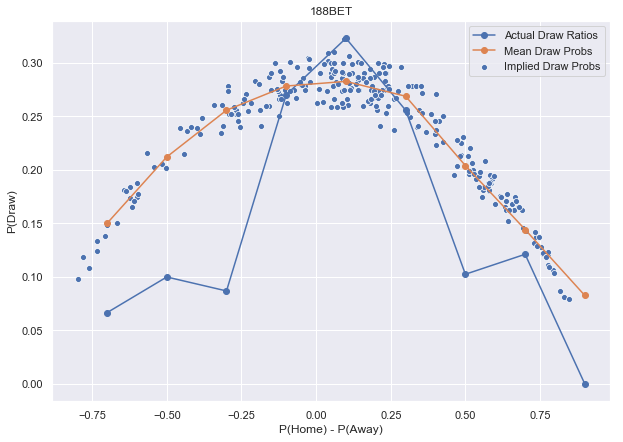

In [32]:
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '188BET'], '188BET')

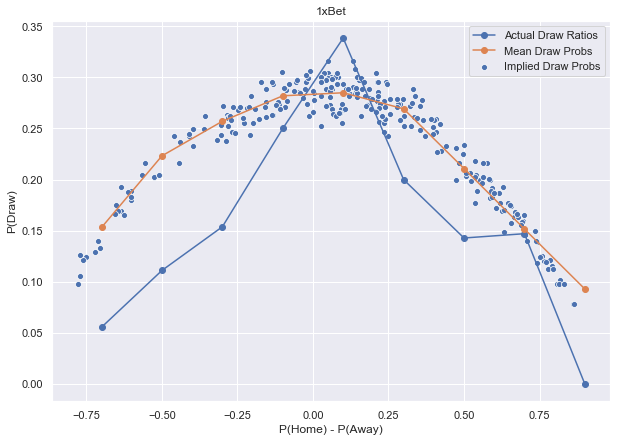

In [33]:
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '1xBet'], '1xBet')

## Task3

In [34]:
# since there are some values like 90+2, time column is stored as string
# so in order to sort correctly, we need to convert 4 to 04 (adding one zero to the left)
goals['time'] = goals['time'].apply(lambda x: x.zfill(2))
booking['time'] = booking['time'].apply(lambda x: x.zfill(2))

# since we will deal with changes in scores, all observations must be time ordered
goals = goals.sort_values(['match_id', 'time'])

In [35]:
def score_difference(col_str):
  """
  first converts '4 - 1' to [4, 1]
  and then returns max(score_list) - min(score_list), 3
  """
  score_list = [int(i) for i in col_str.split('-')]
  return max(score_list) - min(score_list)

In [36]:
# find all score differences for each match in each goal (we will use this info 
# to check whether this difference increased with last goal or not)
goals['score_diff'] = goals['score'].apply(lambda x: score_difference(x))
goals["prev_score"] = goals["score_diff"].groupby(goals['match_id']).shift(1)

In [37]:
goals.head()

,match_id,time,home_scorer,score,away_scorer,score_diff,prev_score
59,13274,18,Vardy J.,1 - 0,NaN,1,NaN
60,13274,29,Gray D.,2 - 0,NaN,2,1.0
61,13275,52,Murray G.,1 - 1,NaN,0,NaN
55,13276,51,NaN,0 - 1,Hazard E.,1,NaN
56,13278,50,Milivojevic L.,1 - 2,NaN,1,NaN


In [38]:
extra_time_goals = goals[goals['time'] > '90']
critical_goals = extra_time_goals[(extra_time_goals['score_diff'] == 0) | (extra_time_goals['prev_score'] == 0)]

In [39]:
critical_goals.head()

,match_id,time,home_scorer,score,away_scorer,score_diff,prev_score
57,13278,90+7,Zaha W.,2 - 2,NaN,0,1.0
30,13296,90+2,Cleverley T.,2 - 1,NaN,1,0.0
131,63572,90+6,Sterling R.,2 - 1,NaN,1,0.0
147,66081,90+2,McArthur J.,2 - 1,NaN,1,0.0
172,67049,90+1,Morata A.,2 - 1,NaN,1,0.0


In [40]:
red_card_matches = booking[(booking['time'] < '46') & (booking['card'] == 'red card')]

In [41]:
match_results = final_bets[final_bets['odd_bookmakers'] == '1xBet']\
                [['match_id', 'norm_prob_odd_1', 'norm_prob_odd_x', 'norm_prob_odd_2', 'result']]
match_results.merge(red_card_matches, on='match_id')

,match_id,norm_prob_odd_1,norm_prob_odd_x,norm_prob_odd_2,result,time,home_fault,card,away_fault
0,158697,0.856698,0.098520,0.044782,1,28,Duffy S.,red card,NaN
1,167048,0.816704,0.125647,0.057650,1,19,NaN,red card,Boly W.
2,186626,0.306408,0.290091,0.403501,2,04,NaN,red card,Maguire H.
3,200965,0.292322,0.261224,0.446455,2,11,Deeney T.,red card,NaN
4,208233,0.221896,0.239214,0.538890,1,43,NaN,red card,Son Heung-Min
5,224446,0.387024,0.304090,0.308886,2,30,Andone F.,red card,NaN
6,224474,0.705463,0.186780,0.107758,1,41,Maitland-Niles A.,red card,NaN
7,224489,0.633510,0.233795,0.132695,1,43,NaN,red card,Hayden I.
8,224492,0.680759,0.202540,0.116701,1,31,Aurier S.,red card,NaN


In [42]:
critical_matches = critical_goals['match_id'].to_list()
red_card_matches = red_card_matches['match_id'].to_list()

In [43]:
matches_to_remove = critical_matches + red_card_matches

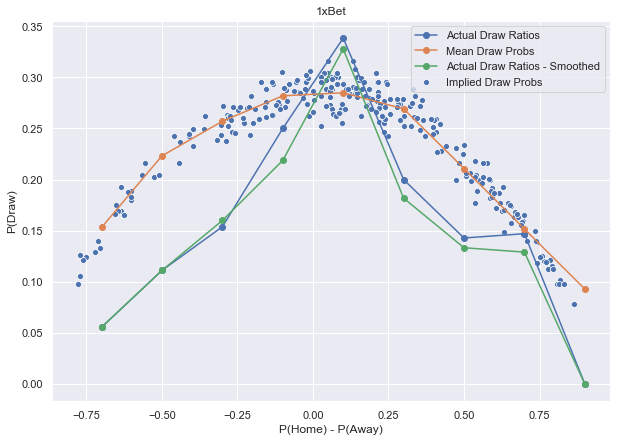

In [44]:
critical_df = final_bets[(~final_bets['match_id'].isin(matches_to_remove)) & (final_bets['odd_bookmakers'] == '1xBet')]
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '1xBet'], '1xBet', critical_df)

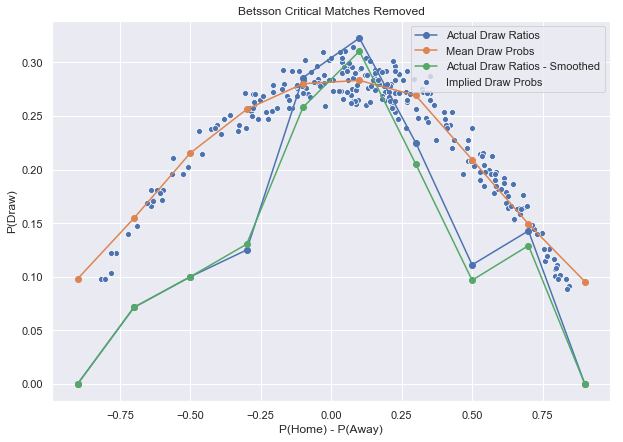

In [45]:
critical_df = final_bets[(~final_bets['match_id'].isin(matches_to_remove)) & (final_bets['odd_bookmakers'] == 'Betsson')]
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == 'Betsson'], 'Betsson Critical Matches Removed', critical_df)

In [46]:
print(len(final_bets[(~final_bets['match_id'].isin(matches_to_remove)) & (final_bets['odd_bookmakers'] == '10Bet')]))
print(len(final_bets[final_bets['odd_bookmakers'] == '10Bet']))

247
266


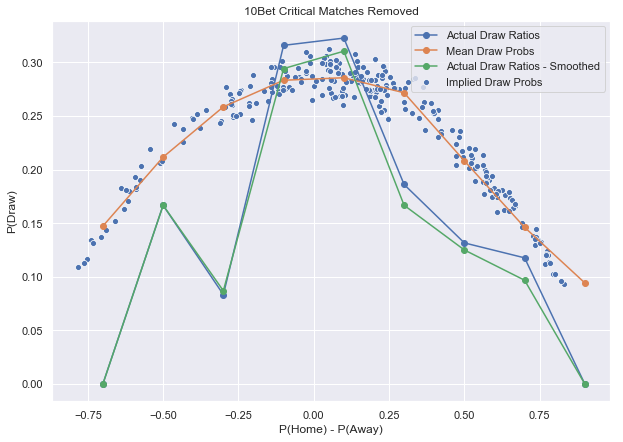

In [47]:
critical_df = final_bets[(~final_bets['match_id'].isin(matches_to_remove)) & (final_bets['odd_bookmakers'] == '10Bet')]
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '10Bet'], '10Bet Critical Matches Removed', critical_df)

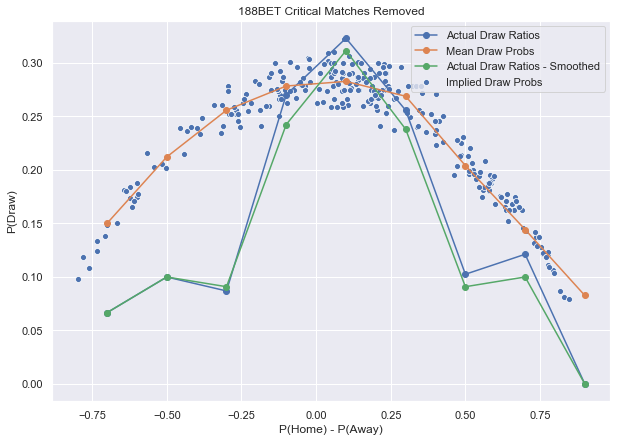

In [48]:
critical_df = final_bets[(~final_bets['match_id'].isin(matches_to_remove)) & (final_bets['odd_bookmakers'] == '188BET')]
plot_bookmaker_odds(final_bets[final_bets['odd_bookmakers'] == '188BET'], '188BET Critical Matches Removed', critical_df)